In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
#Load dataset (student Portuguese scores)
import pandas as pd
d= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/student-por.csv', sep=';')
len(d) 

649

In [70]:
# generate binary Label (pass/fail) based on G1+G2+G3 (test grades, each 0-20 pts); threshold for passing is sum>=30
d['pass']=d.apply(lambda row: 1 if (row['G1']+row['G2']+row['G3']) >= 35 else 0, axis=1)
d=d.drop(['G1','G2','G3'],axis=1)
d.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,1
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,1
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,1


In [71]:
# use one-hot encoding on categorical columns
d = pd.get_dummies(d,columns=['sex','school','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic'])
d.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,pass,sex_F,sex_M,school_GP,school_MS,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,1,3,4,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,2,0,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,3,3,6,1,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,1,5,0,1,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,2,5,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0


In [72]:
# shuffle rows
d = d.sample(frac=1)
# split training and testing data
d_train = d[:500]
d_test = d[500:]

d_train_att = d_train.drop(['pass'], axis=1)
d_train_pass = d_train['pass']

d_test_att = d_test.drop(['pass'], axis=1)
d_test_pass = d_test['pass']

d_att = d.drop(['pass'], axis=1)
d_pass = d['pass']

# number of passing students in whole dataset:
import numpy as np
print("Passing: %d out of %d (%.2f%%)" % (np.sum(d_pass), len(d_pass), 100*float(np.sum(d_pass))/len(d_pass)))

Passing: 328 out of 649 (50.54%)


In [73]:
# fit a decision tree
from sklearn import tree
t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)
t = t.fit(d_train_att, d_train_pass)

In [74]:
# save tree
tree.export_graphviz(t, out_file="student-performance.dot", label="all", impurity=False, proportion=True, feature_names = list(d_train_att), class_names=["fail","pass"], filled=True, rounded=True)

In [75]:
t.score(d_test_att, d_test_pass)

0.7114093959731543

In [76]:
t.score(d_test_att, d_test_pass)
predict = t.predict(d_test_att)
print(predict)

import collections, numpy
a= collections.Counter(predict)
print(a)

[1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1
 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0
 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1
 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0
 0]
Counter({1: 79, 0: 70})


In [77]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(t, d_att, d_pass, cv=5)
# show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.69 (+/- 0.06)


In [78]:
for max_depth in range(1, 20):
  t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
  scores = cross_val_score(t,d_att,d_pass,cv=5)
  print("Max depth: %d, Accuracy: %0.2f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std() * 2))

Max depth: 1, Accuracy: 0.64 (+/- 0.04)
Max depth: 2, Accuracy: 0.69 (+/- 0.04)
Max depth: 3, Accuracy: 0.68 (+/- 0.07)
Max depth: 4, Accuracy: 0.70 (+/- 0.07)
Max depth: 5, Accuracy: 0.70 (+/- 0.05)
Max depth: 6, Accuracy: 0.69 (+/- 0.05)
Max depth: 7, Accuracy: 0.66 (+/- 0.01)
Max depth: 8, Accuracy: 0.65 (+/- 0.03)
Max depth: 9, Accuracy: 0.66 (+/- 0.05)
Max depth: 10, Accuracy: 0.65 (+/- 0.01)
Max depth: 11, Accuracy: 0.65 (+/- 0.02)
Max depth: 12, Accuracy: 0.66 (+/- 0.09)
Max depth: 13, Accuracy: 0.66 (+/- 0.07)
Max depth: 14, Accuracy: 0.62 (+/- 0.08)
Max depth: 15, Accuracy: 0.63 (+/- 0.08)
Max depth: 16, Accuracy: 0.65 (+/- 0.09)
Max depth: 17, Accuracy: 0.62 (+/- 0.08)
Max depth: 18, Accuracy: 0.64 (+/- 0.09)
Max depth: 19, Accuracy: 0.63 (+/- 0.12)


In [79]:
depth_acc = np.empty((19,3), float)
i = 0
for max_depth in range(1, 20):
  t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
  scores = cross_val_score(t, d_att, d_pass, cv=5)
  depth_acc[i,0] = max_depth
  depth_acc[i,1] = scores.mean()
  depth_acc[i,2] = scores.std() * 2
  i += 1

depth_acc

array([[ 1.  ,  0.64,  0.04],
       [ 2.  ,  0.69,  0.04],
       [ 3.  ,  0.68,  0.07],
       [ 4.  ,  0.7 ,  0.07],
       [ 5.  ,  0.7 ,  0.06],
       [ 6.  ,  0.68,  0.03],
       [ 7.  ,  0.67,  0.02],
       [ 8.  ,  0.67,  0.04],
       [ 9.  ,  0.65,  0.04],
       [10.  ,  0.66,  0.03],
       [11.  ,  0.66,  0.03],
       [12.  ,  0.65,  0.07],
       [13.  ,  0.65,  0.05],
       [14.  ,  0.66,  0.1 ],
       [15.  ,  0.64,  0.13],
       [16.  ,  0.65,  0.09],
       [17.  ,  0.64,  0.12],
       [18.  ,  0.65,  0.12],
       [19.  ,  0.62,  0.09]])

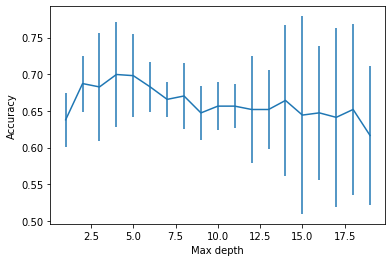

In [80]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.errorbar(depth_acc[:,0], depth_acc[:,1], yerr=depth_acc[:,2])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.show()

Confusion matrix, without normalization
[[51 24]
 [19 55]]


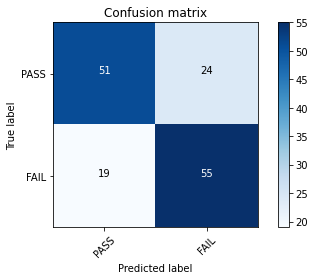

In [81]:
# create a confusion matrix
# Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(d_test_pass, predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PASS','FAIL'], title='Confusion matrix')

# Explain confusion matrix

True Positive: 55

True Negative: 51

False Positive: 24

False Negative 19

the numbers on the diagonal of the confusion matrix correspond to correct predictions.

In [85]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(d_test_pass, predict).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)


True Negatives:  51
False Positives:  24
False Negatives:  19
True Positives:  55
